# Kaggle
## Competição DSA de Machine Learning - Dezembro 2019

Versão 1.0.0: LB = 0.48866 CV = 0.463102
- modelo: LightGBM (com algumas otimizações)
- features engineering: gerado através do Auto_ViML

Versão 1.0.1: LB = 0.48991 CV = 0.462946
- modelo: LightGBM (com algumas otimizações)
- features engineering: gerado através do Auto_ViML (com novas features)

Versão 1.0.2: LB = 0.48915 CV = 0.464442
- modelo: LightGBM (com algumas otimizações)
- features engineering: gerado através do Auto_ViML (com agrupamento pela coluna v2)

Versão 1.0.3: LB = 0.88299 CV = 0.344659
- modelo: LightGBM (com algumas otimizações)
- features engineering: gerado interno

Versão 1.0.4: LB = 0.6041 CV = 0.461724
- modelo: LightGBM (com algumas otimizações)
- features engineering: gerado através do Auto_ViML (modificado v1)

Versão 1.0.5: LB = 0.48897 CV = 0.466055 (kfold)   CV = 0.466422 (StratifiedKFold)
- modelo: LightGBM (com algumas otimizações)
- features engineering: gerado com pacotes estatisticos

# Importando as bibliotecas

In [1]:
# Importar os principais pacotes
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
%matplotlib inline

import time
import datetime
import gc

# Evitar que aparece os warnings
import warnings
warnings.filterwarnings("ignore")

# Seta algumas opções no Jupyter para exibição dos datasets
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

# Variavel para controlar o treinamento no Kaggle
TRAIN_OFFLINE = True

In [2]:
# Importa os pacotes de algoritmos
import lightgbm as lgb
from lightgbm.sklearn import LGBMClassifier

# Importa pacotes do sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, log_loss
from sklearn.preprocessing import scale, MinMaxScaler, StandardScaler


# Carregando os dados de treino e teste

In [7]:
def read_data():
    
    print('Carregando arquivo dataset_treino_new.csv....')
    train = pd.read_csv('../dataset/dataset_treino_new.csv')
    print('dataset_treino.csv tem {} linhas and {} colunas'.format(train.shape[0], train.shape[1]))

    print('Carregando arquivo dataset_teste_new.csv....')
    test = pd.read_csv('../dataset/dataset_teste_new.csv')
    print('dataset_teste.csv tem {} linhas and {} colunas'.format(test.shape[0], test.shape[1]))
    
    return train, test

In [8]:
# Leitura dos dados
train, test = read_data()

Carregando arquivo dataset_treino_new.csv....
dataset_treino.csv tem 114321 linhas and 192 colunas
Carregando arquivo dataset_teste_new.csv....
dataset_teste.csv tem 114393 linhas and 192 colunas


In [9]:
train.head()

,target,v1,v10,v100,v101,v102,v103,v104,v105,v106,v107,v108,v109,v11,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119,v12,v120,v121,v122,v123,v124,v125,v126,v127,v128,v129,v13,v130,v131,v14,v15,v16,v17,v18,v19,v2,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v3,v30,v31,v32,v33,v34,v35,v36,v37,v38,v39,v4,v40,v41,v42,v43,v44,v45,v46,v47,v48,v49,v5,v50,v51,v52,v53,v54,v55,v56,v57,v58,v59,v6,v60,v61,v62,v63,v64,v65,v66,v67,v68,v69,v7,v70,v71,v72,v73,v74,v75,v76,v77,v78,v79,v8,v80,v81,v82,v83,v84,v85,v86,v87,v88,v89,v9,v90,v91,v92,v93,v94,v95,v96,v97,v98,v99,pca_1,ica_1,tsvd_1,grp_1,srp_1,pca_2,ica_2,tsvd_2,grp_2,srp_2,pca_3,ica_3,tsvd_3,grp_3,srp_3,pca_4,ica_4,tsvd_4,grp_4,srp_4,pca_5,ica_5,tsvd_5,grp_5,srp_5,pca_6,ica_6,tsvd_6,grp_6,srp_6,pca_7,ica_7,tsvd_7,grp_7,srp_7,pca_8,ica_8,tsvd_8,grp_8,srp_8,pca_9,ica_9,tsvd_9,grp_9,srp_9,pca_10,ica_10,tsvd_10,grp_10,srp_10,pca_11,ica_11,tsvd_11,grp_11,srp_11,pca_12,ica_12,tsvd_12,grp_12,srp_12
0,1.0,1.335739,0.503281,19.470199,8.389237,2.757375,4.374296,1.574039,0.007294,12.579184,4,2.382692,3.930922,16.434108,1,0.433213,15,25,15.634907,2.857144,1.951220,6.592012,5.909091,-6.297423e-07,6.085711,1.059603,0.803572,8.000000,1.989780,0.035754,21,1.804126,3.113719,2.024285,0,2.866830,0.636365,2.857144,11.636387,1.355013,8.571429,3.670350,0.106720,0.148883,8.727474,18.869283,7.730923,21417,-1.716131e-08,2,0.139412,1.720818,3.393503,0.590122,8.880867,2,2,0,1.083033,1.010829,7.270147,8.375452,11.326592,0.454546,0,4.012088,3.921026,7.711453,7.653429,12.707581,2.015505,10.498338,9.848672,0.113561,2,12.171733,8.086643,7.915266,0.899420,7.277792,6,16.747968,0.037096,1.299638,90,3.971118,0.529802,10.890984,2.599278,1.588448,15.858152,1,0.153461,6.363189,18.303925,2,9.314079,15.231789,17.142857,3.176895,11.784549,5,1,1.614988,1,3,2.230940,7.292418,8.571429,4,0.012941,3.000000,7.528326,8.861647,0.649820,1.299638,1.707317,0.866426,9.551836,3.321300,0.095678,9.999999,0.905342,0,0.442252,5.814018,3.517720,0.462019,7.436824,5.454545,8.877414,1.191337,-9594.327040,0.000791,21417.288045,-3276.946354,-13.411631,-21.402655,0.001696,-34.704936,-1684.945961,-32.712279,23.650855,0.000816,-35.237645,-7670.854166,-91.845839,-15.231836,-0.001601,5.132428,-4594.638439,25.758213,-4.498098,0.001648,-15.068832,-5392.184665,-56.481449,-4.593772,0.002903,-6.412218,1358.112614,50.840950,2.713828,-0.001340,-1.910372,-3281.270873,-9.802000,2.614413,0.000902,3.418111,3969.626674,-27.904933,0.602843,-0.002134,-2.541637,15339.816145,-4.361689,-0.335673,0.002095,0.295882,9736.765346,21.705324,-1.495551,0.001516,-0.507048,-2103.906950,16.414498,0.287991,0.000181,1.813369,-8354.976687,-41.686171
1,1.0,1.629654,1.312910,12.085858,6.860181,2.892925,5.300739,2.645480,1.505335,11.782091,1,1.825361,4.247858,15.447102,0,3.368709,21,17,10.308044,10.547494,2.290506,10.595357,8.365337,3.172134e+00,6.507647,1.293646,2.740819,6.822829,3.553440,0.598896,6,1.672581,3.238717,1.957825,0,3.803983,1.929087,1.737822,11.636386,2.082339,4.919323,3.826746,0.844345,0.222531,7.450246,17.772417,6.763110,9923,1.094562e+00,2,3.056144,1.875622,2.740952,5.099203,8.206934,2,2,0,1.623391,2.163892,3.615077,8.120978,14.579479,0.741054,0,1.245425,4.143181,14.305766,7.183613,12.928289,2.215501,10.789559,9.139068,2.449959,4,12.544372,8.018340,9.191265,1.379210,7.199671,6,15.710541,1.129469,1.561257,106,4.077736,7.706714,10.583058,2.436143,1.713995,14.579344,2,2.544736,6.335429,15.844055,0,9.288946,17.553996,9.450073,2.483027,12.053353,5,2,2.434758,1,3,2.401565,7.307682,13.339980,3,2.301630,2.208907,7.277655,3.430691,2.176982,1.608729,2.819084,1.221162,9.848004,1.924276,2.678584,9.031849,0.966763,1,0.583518,5.470691,3.854661,0.667052,6.457928,7.623643,8.303967,1.249271,1899.671190,-0.000750,9923.613854,-1525.542788,-19.261574,-38.225492,-0.000195,52.644527,-754.106247,-37.350211,39.701139,-0.000033,-46.110005,-3570.013259,-110.713867,-1.216311,-0.004074,20.194310,-2115.570246,13.593542,2.970022,0.000355,-1.114482,-2498.785861,-56.080556,-2.442067,-0.000765,3.129228,601.9

In [10]:
test.head()

,target,v1,v10,v100,v101,v102,v103,v104,v105,v106,v107,v108,v109,v11,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119,v12,v120,v121,v122,v123,v124,v125,v126,v127,v128,v129,v13,v130,v131,v14,v15,v16,v17,v18,v19,v2,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v3,v30,v31,v32,v33,v34,v35,v36,v37,v38,v39,v4,v40,v41,v42,v43,v44,v45,v46,v47,v48,v49,v5,v50,v51,v52,v53,v54,v55,v56,v57,v58,v59,v6,v60,v61,v62,v63,v64,v65,v66,v67,v68,v69,v7,v70,v71,v72,v73,v74,v75,v76,v77,v78,v79,v8,v80,v81,v82,v83,v84,v85,v86,v87,v88,v89,v9,v90,v91,v92,v93,v94,v95,v96,v97,v98,v99,pca_1,ica_1,tsvd_1,grp_1,srp_1,pca_2,ica_2,tsvd_2,grp_2,srp_2,pca_3,ica_3,tsvd_3,grp_3,srp_3,pca_4,ica_4,tsvd_4,grp_4,srp_4,pca_5,ica_5,tsvd_5,grp_5,srp_5,pca_6,ica_6,tsvd_6,grp_6,srp_6,pca_7,ica_7,tsvd_7,grp_7,srp_7,pca_8,ica_8,tsvd_8,grp_8,srp_8,pca_9,ica_9,tsvd_9,grp_9,srp_9,pca_10,ica_10,tsvd_10,grp_10,srp_10,pca_11,ica_11,tsvd_11,grp_11,srp_11,pca_12,ica_12,tsvd_12,grp_12,srp_12
0,NaN,1.375465e+00,1.312911,19.708030,4.186787,1.873945,4.129022,1.701894,0.004535,11.688117,1,1.502480,2.121710,16.851853,0,3.568773,21,25,12.246698,11.428572,1.276596,4.777902,5.833334,-9.974950e-07,6.961173,1.459854,3.267328,7.619048,1.815241,1.112270e-07,6,1.292368,3.903345,1.485925,0,3.107462,2.333334,1.428572e+00,12.230137,1.773050,2.857142,3.493816,0.096826,0.225481,11.361141,17.910227,7.437806,3924,9.558310e-07,4,0.069180,0.954152,4.386616,0.573017,6.988848,2,7,0,1.115242,2.081784,5.228503,8.178438,12.183225,8.333339e-01,0,2.842768e+00,4.200778,11.754576,6.765800,10.855019,1.296297,10.613377,9.417172,0.100480,9,12.774528,7.509293,6.577000,0.118847,8.590755,2,17.021277,0.044313,1.338291,6,2.602230,2.919712e-01,9.038609,2.081784,0.817843,14.911512,1,0.091466,5.967949,15.611474,0,8.029739,15.912409,8.571429,1.784386,11.222210,5,1,1.929013,1,3,2.146860,6.171004,15.714287,16,0.011094,1.904761,8.918731,8.750729,2.453532,0.892192,1.860465,-0.892193,7.904968,1.784387,0.105298,9.523810,0.988980,1,0.658269,4.929298,2.992365,0.759955,5.947955,4.999999,10.013503,0.817844,7898.673506,0.000535,3924.339294,-599.798074,-15.980569,61.796328,0.003355,23.293083,-286.479525,-34.619749,40.680839,-0.006664,24.192350,-1414.169995,-15.182312,-14.883880,-0.003457,50.711126,-821.968470,24.578869,3.117360,0.000059,-14.547169,-959.253583,-42.016392,-11.416287,-0.002641,-0.686902,249.623571,38.230895,6.198669,-0.000466,-13.651806,-618.433494,-11.898589,-0.515298,-0.002761,3.630024,745.619090,-21.437602,2.901704,-0.003128,0.497340,2795.923202,-4.130049,10.756430,0.002094,3.738234,1768.715431,25.931736,3.090649,0.000567,11.019473,-416.882127,15.154343,-3.409249,-0.002192,0.166330,-1532.228956,-42.791109
1,NaN,1.629654e+00,1.291029,12.085858,6.860181,2.892925,5.300739,2.645480,1.084907,11.782091,3,2.150339,4.177810,15.447102,1,3.368709,4,25,16.284938,10.547494,2.290506,8.297663,8.365337,3.172134e+00,6.618289,1.293646,2.740819,6.822829,3.553440,9.293436e-01,72,1.672581,3.238717,2.029484,0,3.803983,1.929087,1.737822e+00,10.760796,2.082339,4.919323,3.826746,0.844345,0.222531,7.450246,17.772417,5.895192,9043,1.094562e+00,3,1.702109,1.875622,2.740952,5.099203,8.206934,2,0,0,1.623391,2.163892,8.387431,8.120978,13.367250,7.410539e-01,4,1.245425e+00,4.143181,6.737574,7.183613,12.928289,2.215501,10.789559,9.139068,1.635067,2,12.544372,8.018340,8.741077,1.027070,7.199671,0,15.710541,1.255222,1.561257,90,4.077736,7.706714e+00,10.583058,2.436143,1.713995,14.579344,1,1.691136,6.335429,15.844055,2,9.288946,17.553996,9.450073,2.483027,12.270262,5,5,2.434758,1,3,2.401565,7.307682,13.339980,4,1.504411,2.208907,7.286325,6.221413,2.176982,1.608729,2.819084,1.221162,10.177101,1.924276,1.519508,9.031849,0.966763,2,0.583518,5.470691,3.854661,0.667052,6.457928,7.623643,7.665333,1.249271,2779.674852,-0.000073,9043.757374,-1368.957759,-13.082210,-20.960349,0.000090,73.167274,-683.399347,27.740556,-26.408214,0.001013,10.798330,-3264.208023,-89.349651,1.535109,0.001694,-15.243685,-1906.239999,20.429457,-5.472609,-0.000090,1.627026,-2274.500784,-58.15776

In [11]:
df = train.append(test)

In [12]:
df.head()

,target,v1,v10,v100,v101,v102,v103,v104,v105,v106,v107,v108,v109,v11,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119,v12,v120,v121,v122,v123,v124,v125,v126,v127,v128,v129,v13,v130,v131,v14,v15,v16,v17,v18,v19,v2,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v3,v30,v31,v32,v33,v34,v35,v36,v37,v38,v39,v4,v40,v41,v42,v43,v44,v45,v46,v47,v48,v49,v5,v50,v51,v52,v53,v54,v55,v56,v57,v58,v59,v6,v60,v61,v62,v63,v64,v65,v66,v67,v68,v69,v7,v70,v71,v72,v73,v74,v75,v76,v77,v78,v79,v8,v80,v81,v82,v83,v84,v85,v86,v87,v88,v89,v9,v90,v91,v92,v93,v94,v95,v96,v97,v98,v99,pca_1,ica_1,tsvd_1,grp_1,srp_1,pca_2,ica_2,tsvd_2,grp_2,srp_2,pca_3,ica_3,tsvd_3,grp_3,srp_3,pca_4,ica_4,tsvd_4,grp_4,srp_4,pca_5,ica_5,tsvd_5,grp_5,srp_5,pca_6,ica_6,tsvd_6,grp_6,srp_6,pca_7,ica_7,tsvd_7,grp_7,srp_7,pca_8,ica_8,tsvd_8,grp_8,srp_8,pca_9,ica_9,tsvd_9,grp_9,srp_9,pca_10,ica_10,tsvd_10,grp_10,srp_10,pca_11,ica_11,tsvd_11,grp_11,srp_11,pca_12,ica_12,tsvd_12,grp_12,srp_12
0,1.0,1.335739,0.503281,19.470199,8.389237,2.757375,4.374296,1.574039,0.007294,12.579184,4,2.382692,3.930922,16.434108,1,0.433213,15,25,15.634907,2.857144,1.951220,6.592012,5.909091,-6.297423e-07,6.085711,1.059603,0.803572,8.000000,1.989780,0.035754,21,1.804126,3.113719,2.024285,0,2.866830,0.636365,2.857144,11.636387,1.355013,8.571429,3.670350,0.106720,0.148883,8.727474,18.869283,7.730923,21417,-1.716131e-08,2,0.139412,1.720818,3.393503,0.590122,8.880867,2,2,0,1.083033,1.010829,7.270147,8.375452,11.326592,0.454546,0,4.012088,3.921026,7.711453,7.653429,12.707581,2.015505,10.498338,9.848672,0.113561,2,12.171733,8.086643,7.915266,0.899420,7.277792,6,16.747968,0.037096,1.299638,90,3.971118,0.529802,10.890984,2.599278,1.588448,15.858152,1,0.153461,6.363189,18.303925,2,9.314079,15.231789,17.142857,3.176895,11.784549,5,1,1.614988,1,3,2.230940,7.292418,8.571429,4,0.012941,3.000000,7.528326,8.861647,0.649820,1.299638,1.707317,0.866426,9.551836,3.321300,0.095678,9.999999,0.905342,0,0.442252,5.814018,3.517720,0.462019,7.436824,5.454545,8.877414,1.191337,-9594.327040,0.000791,21417.288045,-3276.946354,-13.411631,-21.402655,0.001696,-34.704936,-1684.945961,-32.712279,23.650855,0.000816,-35.237645,-7670.854166,-91.845839,-15.231836,-0.001601,5.132428,-4594.638439,25.758213,-4.498098,0.001648,-15.068832,-5392.184665,-56.481449,-4.593772,0.002903,-6.412218,1358.112614,50.840950,2.713828,-0.001340,-1.910372,-3281.270873,-9.802000,2.614413,0.000902,3.418111,3969.626674,-27.904933,0.602843,-0.002134,-2.541637,15339.816145,-4.361689,-0.335673,0.002095,0.295882,9736.765346,21.705324,-1.495551,0.001516,-0.507048,-2103.906950,16.414498,0.287991,0.000181,1.813369,-8354.976687,-41.686171
1,1.0,1.629654,1.312910,12.085858,6.860181,2.892925,5.300739,2.645480,1.505335,11.782091,1,1.825361,4.247858,15.447102,0,3.368709,21,17,10.308044,10.547494,2.290506,10.595357,8.365337,3.172134e+00,6.507647,1.293646,2.740819,6.822829,3.553440,0.598896,6,1.672581,3.238717,1.957825,0,3.803983,1.929087,1.737822,11.636386,2.082339,4.919323,3.826746,0.844345,0.222531,7.450246,17.772417,6.763110,9923,1.094562e+00,2,3.056144,1.875622,2.740952,5.099203,8.206934,2,2,0,1.623391,2.163892,3.615077,8.120978,14.579479,0.741054,0,1.245425,4.143181,14.305766,7.183613,12.928289,2.215501,10.789559,9.139068,2.449959,4,12.544372,8.018340,9.191265,1.379210,7.199671,6,15.710541,1.129469,1.561257,106,4.077736,7.706714,10.583058,2.436143,1.713995,14.579344,2,2.544736,6.335429,15.844055,0,9.288946,17.553996,9.450073,2.483027,12.053353,5,2,2.434758,1,3,2.401565,7.307682,13.339980,3,2.301630,2.208907,7.277655,3.430691,2.176982,1.608729,2.819084,1.221162,9.848004,1.924276,2.678584,9.031849,0.966763,1,0.583518,5.470691,3.854661,0.667052,6.457928,7.623643,8.303967,1.249271,1899.671190,-0.000750,9923.613854,-1525.542788,-19.261574,-38.225492,-0.000195,52.644527,-754.106247,-37.350211,39.701139,-0.000033,-46.110005,-3570.013259,-110.713867,-1.216311,-0.004074,20.194310,-2115.570246,13.593542,2.970022,0.000355,-1.114482,-2498.785861,-56.080556,-2.442067,-0.000765,3.129228,601.9

# Algoritmo LigthGBM


In [27]:
# Configurações Gerais

GENERATE_SUBMISSION_FILES = True
SUBMISSION_SUFIX = "_lgbm_v.1.0.5"
STRATIFIED_KFOLD = False
RANDOM_SEED = 12345 #737851
NUM_THREADS = 4
NUM_FOLDS = 10
EARLY_STOPPING = 100

LIGHTGBM_PARAMS = {
    'boosting_type': 'goss',
    'n_estimators': 10000,
    'learning_rate': 0.005134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 1,
    'is_unbalance': False,
    'silent':-1,
    'verbose':-1
}

In [28]:
# ------------------------- LIGHTGBM MODEL -------------------------

def run_model(data, categorical_feature = None):
    df = data[data['target'].notnull()]
    test = data[data['target'].isnull()]
    del_features = ['target']
    predictors = list(filter(lambda v: v not in del_features, df.columns))
    
    print("Train/valid shape: {}, test shape: {}".format(df.shape, test.shape))

    if not STRATIFIED_KFOLD:
        folds = KFold(n_splits= NUM_FOLDS, shuffle=True, random_state= RANDOM_SEED)
    else:
        folds = StratifiedKFold(n_splits= NUM_FOLDS, shuffle=True, random_state= RANDOM_SEED)

    # Hold oof predictions, test predictions, feature importance and training/valid auc
    oof_preds = np.zeros(df.shape[0])
    sub_preds = np.zeros(test.shape[0])
    importance_df = pd.DataFrame()
    eval_results = dict()

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df[predictors], df['target'])):
        train_x, train_y = df[predictors].iloc[train_idx], df['target'].iloc[train_idx]
        valid_x, valid_y = df[predictors].iloc[valid_idx], df['target'].iloc[valid_idx]

        params = {'random_state': RANDOM_SEED, 'nthread': NUM_THREADS}
        clf = LGBMClassifier(**{**params, **LIGHTGBM_PARAMS})
        if not categorical_feature:
            clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
                    eval_metric='logloss', verbose=400, early_stopping_rounds= EARLY_STOPPING)
        else:
            clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
                    eval_metric='logloss', verbose=400, early_stopping_rounds=EARLY_STOPPING,
                    feature_name= list(df[predictors].columns), categorical_feature= categorical_feature)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test[predictors], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        # Feature importance by GAIN and SPLIT
        fold_importance = pd.DataFrame()
        fold_importance["feature"] = predictors
        fold_importance["gain"] = clf.booster_.feature_importance(importance_type='gain')
        fold_importance["split"] = clf.booster_.feature_importance(importance_type='split')
        importance_df = pd.concat([importance_df, fold_importance], axis=0)
        eval_results['train_{}'.format(n_fold+1)]  = clf.evals_result_['training']['binary_logloss']
        eval_results['valid_{}'.format(n_fold+1)] = clf.evals_result_['valid_1']['binary_logloss']

        print('Fold %2d Log Loss : %.6f' % (n_fold + 1, log_loss(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full Log Loss score %.6f' % log_loss(df['target'], oof_preds))
    test['target'] = sub_preds.copy()

    # Get the average feature importance between folds
    mean_importance = importance_df.groupby('feature').mean().reset_index()
    mean_importance.sort_values(by= 'gain', ascending=False, inplace=True)
    # Save feature importance, test predictions and oof predictions as csv
    if GENERATE_SUBMISSION_FILES:

        # Save submission (test data) and feature importance
        submission = pd.read_csv('../dataset/sample_submission.csv')
        submission['PredictedProb'] = sub_preds.copy()
        submission.to_csv('../submission/submission{}.csv'.format(SUBMISSION_SUFIX), index=False)
        
        mean_importance.to_csv('feature_importance{}.csv'.format(SUBMISSION_SUFIX), index=False)
        plt.hist(submission.PredictedProb)
        plt.show()
    return mean_importance

Train/valid shape: (114321, 192), test shape: (114393, 192)
Training until validation scores don't improve for 100 rounds
[400]	training's binary_logloss: 0.469252	valid_1's binary_logloss: 0.479595
[800]	training's binary_logloss: 0.451786	valid_1's binary_logloss: 0.47219
[1200]	training's binary_logloss: 0.439504	valid_1's binary_logloss: 0.469942
[1600]	training's binary_logloss: 0.428804	valid_1's binary_logloss: 0.468772
[2000]	training's binary_logloss: 0.418965	valid_1's binary_logloss: 0.46792
[2400]	training's binary_logloss: 0.409897	valid_1's binary_logloss: 0.467579
Early stopping, best iteration is:
[2685]	training's binary_logloss: 0.403871	valid_1's binary_logloss: 0.467023
Fold  1 Log Loss : 0.467023
Training until validation scores don't improve for 100 rounds
[400]	training's binary_logloss: 0.470035	valid_1's binary_logloss: 0.472184
[800]	training's binary_logloss: 0.452393	valid_1's binary_logloss: 0.465192
[1200]	training's binary_logloss: 0.440134	valid_1's bina

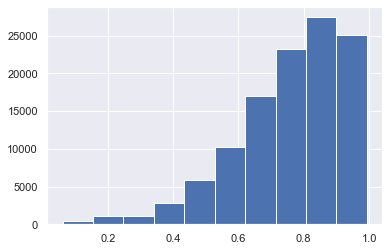

In [29]:
mean_importance = run_model(df)